In [26]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.io import loadmat

For all models, the first step was to import the provided data files: the power trace file (time samples) and the input file (plaintexts). We then implemented the SBOX function in Python based on the cipher specification.


In [59]:
# === Load the measured power traces: each row = one encryption trace ===
with h5py.File('cmos_exper.mat', 'r') as file:
    traces = np.array(file['Imat']).T  # Shape: [num_traces x time_samples]

# === Load the known plaintexts used during encryption ===
with h5py.File('inputs.mat', 'r') as file:
    plaintexts = np.array(file['plain']).squeeze().astype(int)

In [60]:
# === Define the substitution box (S-Box) used by the cipher ===
sbox = np.array([12, 5, 6, 11, 9, 0, 10, 13, 3, 14, 15, 8, 4, 7, 1, 2])

In [27]:
# === Leakage model definitions ===
def hamming_weight(value):
    return bin(value).count('1')

def hamming_distance(val1, val2):
    return bin(val1 ^ val2).count('1')

The analysis was carried out in two main stages:
In the first stage, we used only the plaintexts to compute the hypothetical leakage for each possible key, according to the chosen leakage model (Hamming Weight, Hamming Distance or Value Model).
In the second stage, we computed the correlation between the hypothetical leakage values and the actual power measurements, for every key and every time sample.
At the end, we obtained a correlation matrix where each row corresponds to a key guess and each column to a time sample. From this matrix, we identified the key with the highest correlation and the specific time sample at which this maximum correlation occurred.

## Hamming Weight (HW) Model


  #### i: Implement a CPA script to analyze power traces using the HW model

In [85]:
# === Create the hypothetical leakage values for all key guesses ===
# Matrix of shape [num_traces x 16], each column is leakage for one key guess
hypothetical_leakage = np.zeros((len(plaintexts), 16))
for trace_idx, input in enumerate(plaintexts):
    for key_guess in range(16):
        output = sbox[input ^ key_guess]
        hypothetical_leakage[trace_idx, key_guess] = hamming_weight(output)

# === Compute the correlation matrix ===
# Shape: [16 key guesses x time samples]
num_samples = traces.shape[1]
correlation_matrix = np.zeros((16, num_samples))

# Pearson correlation between leakage model and actual power consumption
for key_guess in range(16):
    for time_idx in range(num_samples):
        corr, _ = pearsonr(hypothetical_leakage[:, key_guess], traces[:, time_idx])
        correlation_matrix[key_guess, time_idx] = abs(corr)  # Use absolute correlation

# === Identify the most likely key guess based on max correlation ===
best_guess, best_sample = np.unravel_index(np.argmax(correlation_matrix), correlation_matrix.shape)

  #### ii: Generate the following plots:

 • Maximum correlation coefficient vs. key guess

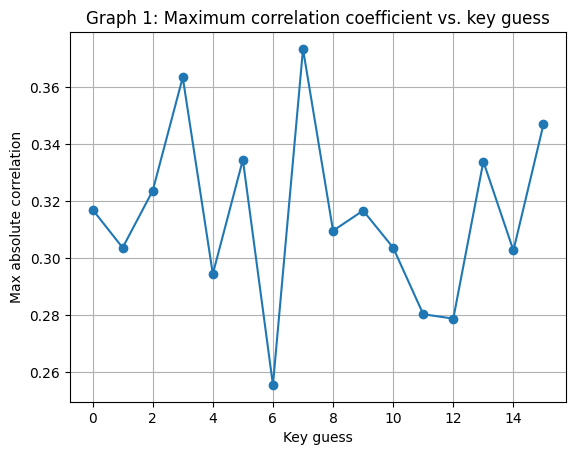

In [86]:
# === Graph 1: Maximum correlation per key guess ===
plt.figure()
plt.plot(np.max(correlation_matrix, axis=1), marker='o')
plt.title("Graph 1: Maximum correlation coefficient vs. key guess")
plt.xlabel("Key guess")
plt.ylabel("Max absolute correlation")
plt.grid()
plt.show()

In the case of the Hamming Distance model, the resulting graph shows that key 7 yields the highest correlation, but the value remains relatively low (only 0.37). This suggests that the model is not particularly effective for this dataset and does not provide a clear distinction between the possible key candidates.


Additionally, the other graphs produced by this model are less relevant, as we have already determined that the model does not provide meaningful insights for our analysis.




 • Correlation coefficient vs. sample (time) for all key guesses

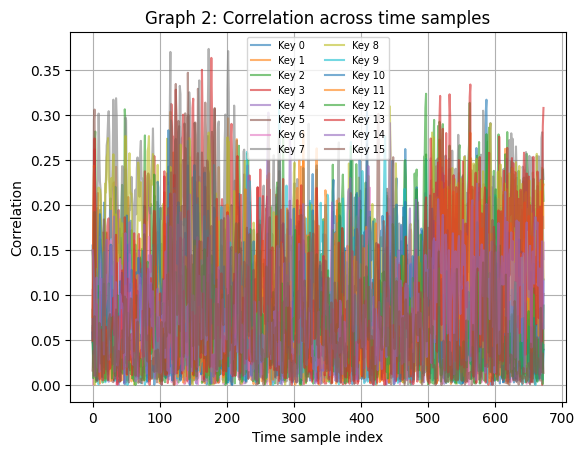

In [87]:
# === Graph 2: Correlation across time for each key guess ===
plt.figure()
for key_guess in range(16):
    plt.plot(correlation_matrix[key_guess], label=f'Key {key_guess}', alpha=0.6)
plt.title("Graph 2: Correlation across time samples")
plt.xlabel("Time sample index")
plt.ylabel("Correlation")
plt.legend(fontsize=7, ncol=2)
plt.grid()
plt.show()

 • Correlation coefficient vs. number of traces for all key guesses

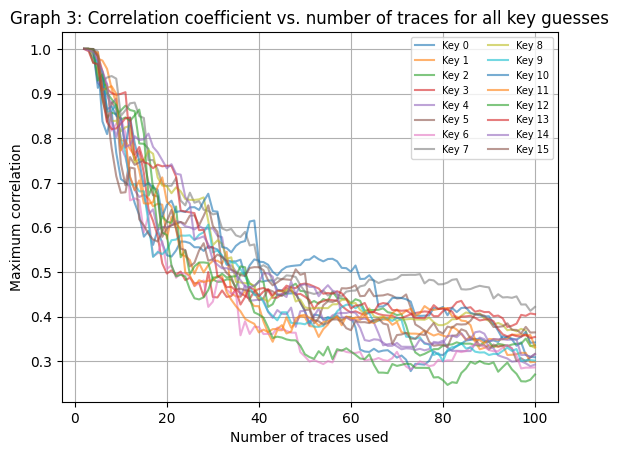

In [84]:
# === Graph 3: Correlation vs. number of traces ===
trace_counts = []
keywise_correlations = [[] for _ in range(16)]

# Loop over increasing number of traces (starting from 2 up to all available)
for n_traces in range(2, len(plaintexts) + 1):
    trace_counts.append(n_traces)
    # For each possible key guess (total of 16 possibilities for 4-bit key)
    for key_guess in range(16):
        max_corr = 0 
        # Loop over all time samples in the power traces
        for time_idx in range(num_samples):
            x = hypothetical_leakage[:n_traces, key_guess]  # Hypothetical leakage values
            y = traces[:n_traces, time_idx]  # Measured power values at the current time sample
            # Skip cases where all values are constant (correlation is undefined or zero)
            if np.all(x == x[0]) or np.all(y == y[0]):
                continue
            # Compute the Pearson correlation between simulated leakage and real trace
            corr = abs(pearsonr(x, y)[0])
            # Update max_corr if the current correlation is higher
            if not np.isnan(corr) and corr > max_corr:
                max_corr = corr
        # Store the maximum correlation for this key guess at this trace count
        keywise_correlations[key_guess].append(max_corr)

plt.figure()
for key_guess in range(16):
    plt.plot(trace_counts, keywise_correlations[key_guess], label=f'Key {key_guess}', alpha=0.6)
plt.title("Graph 3: Correlation coefficient vs. number of traces for all key guesses")
plt.xlabel("Number of traces used")
plt.ylabel("Maximum correlation")
plt.legend(fontsize=7, ncol=2)
plt.grid()
plt.show()

 • Correlation ratio vs. number of traces

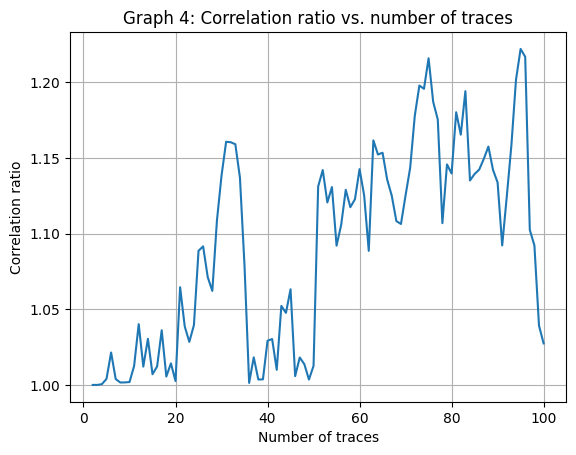

In [ ]:
# === Graph 4: Correlation ratio (best vs second-best) as traces increase ===
# Initialize list to store correlation ratios between best and second-best key guesses
correlation_ratios = []

# Loop over each trace count index (i.e., how many traces were used)
for i in range(len(trace_counts)):
    # Get the maximum correlation value for each key guess at the current trace count
    all_corrs = [keywise_correlations[k][i] for k in range(16)]
    sorted_corrs = sorted(all_corrs, reverse=True)
    # Compute the ratio between the highest and second-highest correlations
    # This helps show how clearly the correct key stands out
    ratio = sorted_corrs[0] / sorted_corrs[1] if sorted_corrs[1] != 0 else 0
    # Store the computed ratio
    correlation_ratios.append(ratio)


plt.figure()
plt.plot(trace_counts, correlation_ratios)
plt.title("Graph 4: Correlation ratio vs. number of traces")
plt.xlabel("Number of traces")
plt.ylabel("Correlation ratio")
plt.grid()
plt.show()

  #### iii: Identify the exact clock cycle where the leakage is most significant. Plot the corresponding correlation coefficient as a function of the number of traces.

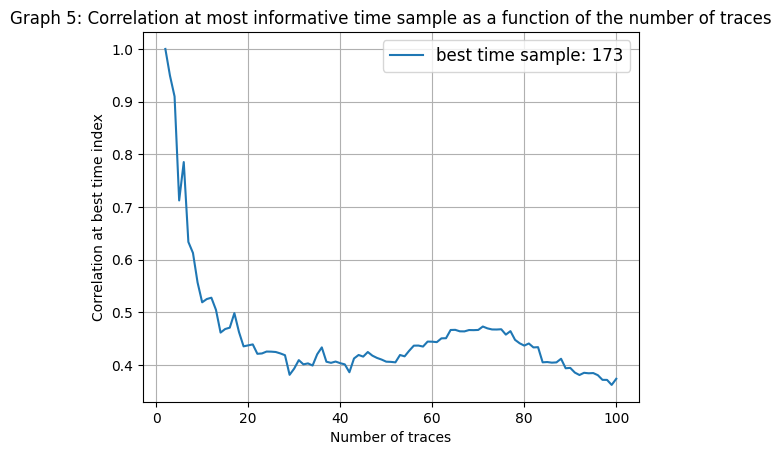

In [ ]:
# === Graph 5: Correlation at best sample over increasing traces ===
fixed_point_corr = []
trace_counts_fixed = []

# Iterate over increasing number of traces, starting from 2 up to the total number of plaintexts
for n_traces in range(2, len(plaintexts) + 1):
    max_corr = 0  
    # Try all possible key guesses (from 0 to 15)
    for key_guess in range(16):
        # Extract the hypothetical leakage and the power trace values at the best time sample
        x = hypothetical_leakage[:n_traces, key_guess]
        y = traces[:n_traces, best_sample]
        # Skip if all values are constant (correlation is undefined or not meaningful)
        if np.all(x == x[0]) or np.all(y == y[0]):
            continue
        # Compute the absolute Pearson correlation
        corr = abs(pearsonr(x, y)[0])
        # Update max correlation if this is the highest seen so far for this number of traces
        if not np.isnan(corr) and corr > max_corr:
            max_corr = corr
    fixed_point_corr.append(max_corr)
    trace_counts_fixed.append(n_traces)

plt.figure()
plt.plot(trace_counts_fixed, fixed_point_corr, label=f'best time sample: {best_sample}')
plt.title("Graph 5: Correlation at most informative time sample as a function of the number of traces")
plt.xlabel("Number of traces")
plt.ylabel("Correlation at best time index")
plt.legend(fontsize=12, ncol=5)
plt.grid()
plt.show()

## Hamming Distance (HD) Model


  #### i: Implement a CPA script to analyze power traces using the HD model

In [ ]:
# === Create the hypothetical leakage values for all key guesses ===
# Matrix of shape [num_traces x 16], each column is leakage for one key guess
hypothetical_leakage = np.zeros((len(plaintexts), 16))
# Loop over each key
for key_guess in range(16):
    prev_output = 0
    # Loop over each input and calculate the Hamming Distance between the current and previous SBOX outputs
    for trace_idx, input in enumerate(plaintexts):
        output = sbox[input ^ key_guess]
        hypothetical_leakage[trace_idx, key_guess] = hamming_distance(prev_output,output)
        prev_output = output

# === Compute the correlation matrix ===
# Shape: [16 key guesses x time samples]
num_samples = traces.shape[1]
correlation_matrix = np.zeros((16, num_samples))

# Pearson correlation between leakage model and actual power consumption
for key_guess in range(16):
    for time_idx in range(num_samples):
        corr, _ = pearsonr(hypothetical_leakage[:, key_guess], traces[:, time_idx])
        correlation_matrix[key_guess, time_idx] = abs(corr)  # Use absolute correlation

# === Identify the most likely key guess based on max correlation ===
best_guess, best_sample = np.unravel_index(np.argmax(correlation_matrix), correlation_matrix.shape)

  #### ii: Generate the following plots:

• Maximum correlation coefficient vs. key guess

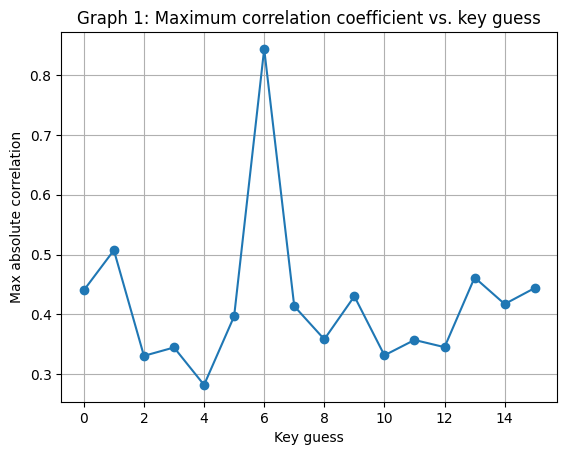

In [73]:
# === Graph 1: Maximum correlation per key guess ===
plt.figure()
plt.plot(np.max(correlation_matrix, axis=1), marker='o')
plt.title("Graph 1: Maximum correlation coefficient vs. key guess")
plt.xlabel("Key guess")
plt.ylabel("Max absolute correlation")
plt.grid()
plt.show()

This time, the graph clearly indicates (with a correlation of 0.85) that the correct key is 6, suggesting that this is likely the most suitable model for performing the attack.

 • Correlation coefficient vs. sample (time) for all key guesses

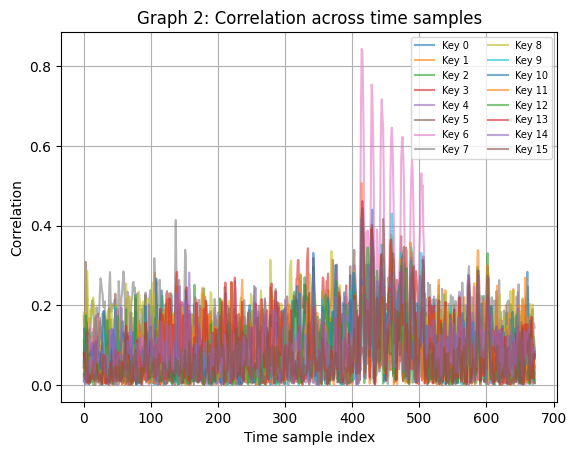

In [74]:
# === Graph 2: Correlation across time for each key guess ===
plt.figure()
for key_guess in range(16):
    plt.plot(correlation_matrix[key_guess], label=f'Key {key_guess}', alpha=0.6)
plt.title("Graph 2: Correlation across time samples")
plt.xlabel("Time sample index")
plt.ylabel("Correlation")
plt.legend(fontsize=7, ncol=2)
plt.grid()
plt.show()

In this graph, key 6 once again stands out significantly above the others. Moreover, the time samples with the highest correlation are concentrated between indices 400 and 500.

 • Correlation coefficient vs. number of traces for all key guesses

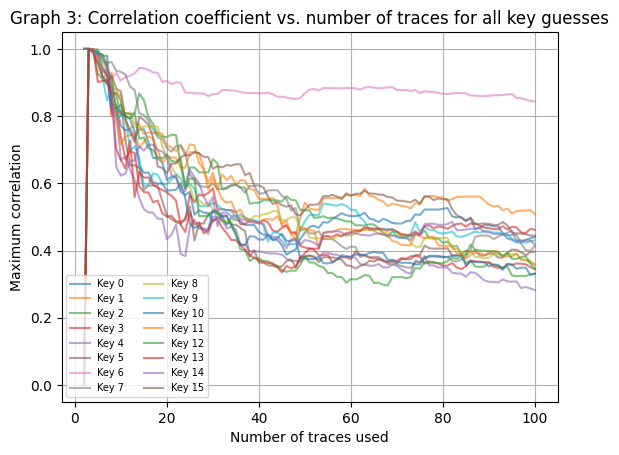

In [ ]:
# === Graph 3: Correlation vs. number of traces ===
trace_counts = []
keywise_correlations = [[] for _ in range(16)]

# Loop over increasing number of traces (starting from 2 up to all available)
for n_traces in range(2, len(plaintexts) + 1):
    trace_counts.append(n_traces)
    # For each possible key guess (total of 16 possibilities for 4-bit key)
    for key_guess in range(16):
        max_corr = 0 
        # Loop over all time samples in the power traces
        for time_idx in range(num_samples):
            x = hypothetical_leakage[:n_traces, key_guess]  # Hypothetical leakage values
            y = traces[:n_traces, time_idx]  # Measured power values at the current time sample
            # Skip cases where all values are constant (correlation is undefined or zero)
            if np.all(x == x[0]) or np.all(y == y[0]):
                continue
            # Compute the Pearson correlation between simulated leakage and real trace
            corr = abs(pearsonr(x, y)[0])
            # Update max_corr if the current correlation is higher
            if not np.isnan(corr) and corr > max_corr:
                max_corr = corr
        # Store the maximum correlation for this key guess at this trace count
        keywise_correlations[key_guess].append(max_corr)

plt.figure()
for key_guess in range(16):
    plt.plot(trace_counts, keywise_correlations[key_guess], label=f'Key {key_guess}', alpha=0.6)
plt.title("Graph 3: Correlation coefficient vs. number of traces for all key guesses")
plt.xlabel("Number of traces used")
plt.ylabel("Maximum correlation")
plt.legend(fontsize=7, ncol=2)
plt.grid()
plt.show()


In the graph above, we observe that as the number of inputs increases, the distinctiveness of key 6 compared to the other keys becomes more pronounced. With only one input, all keys appear to have high correlation, as there's not enough data for meaningful comparison. However, as more inputs are added, the accumulated data allows the statistics to highlight the correct key while pushing the others further behind

 • Correlation ratio vs. number of traces

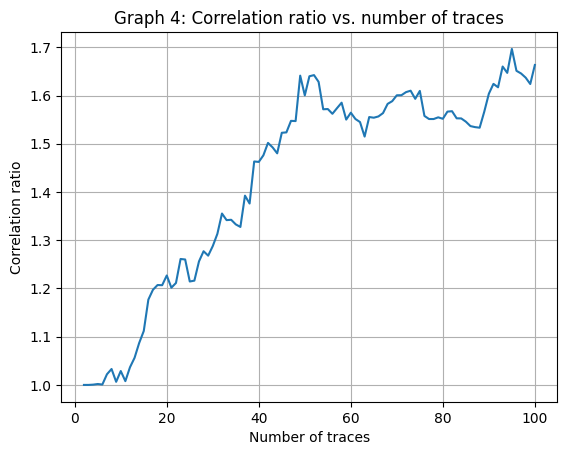

In [ ]:
# === Graph 4: Correlation ratio (best vs second-best) as traces increase ===
correlation_ratios = []
# Loop over each trace count index (i.e., how many traces were used)
for i in range(len(trace_counts)):
    # Get the maximum correlation value for each key guess at the current trace count
    all_corrs = [keywise_correlations[k][i] for k in range(16)]
    sorted_corrs = sorted(all_corrs, reverse=True)
    # Compute the ratio between the highest and second-highest correlations
    # This helps show how clearly the correct key stands out
    ratio = sorted_corrs[0] / sorted_corrs[1] if sorted_corrs[1] != 0 else 0
    # Store the computed ratio
    correlation_ratios.append(ratio)

plt.figure()
plt.plot(trace_counts, correlation_ratios)
plt.title("Graph 4: Correlation ratio vs. number of traces")
plt.xlabel("Number of traces")
plt.ylabel("Correlation ratio")
plt.grid()
plt.show()

The goal of this graph is to examine whether a specific key guess stands out significantly compared to the others. A large gap between the correlation of the best key and the second-best indicates a strong likelihood of correct key identification. In contrast, if all keys have similar correlation values (i.e., the ratio is close to 1), it suggests that there isn't yet a clear distinction.

In this graph, we can see that as the number of inputs increases, the ratio between the strongest key and the next one steadily grows — reaching a value of 1.7. This indicates a significant and promising gap for identifying the correct key.



 ####  iii: Identify the exact clock cycle where the leakage is most significant. Plot the corresponding correlation coefficient as a function of the number of traces.

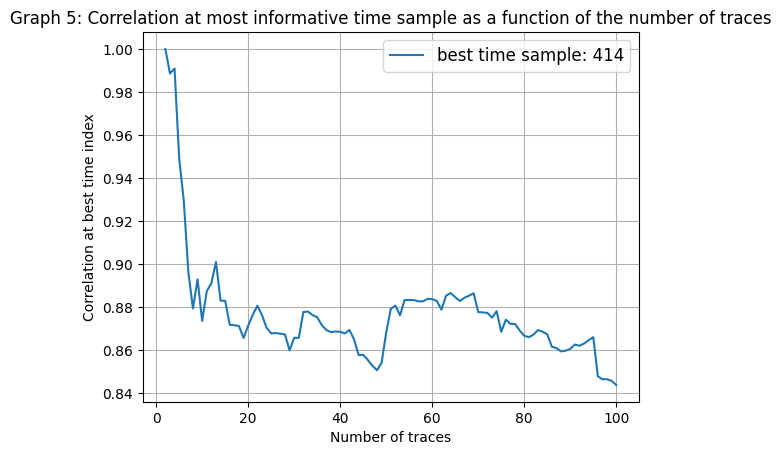

In [ ]:
# === Graph 5: Correlation at best sample over increasing traces ===
fixed_point_corr = []
trace_counts_fixed = []

# Iterate over increasing number of traces, starting from 2 up to the total number of plaintexts
for n_traces in range(2, len(plaintexts) + 1):
    max_corr = 0  
    # Try all possible key guesses (from 0 to 15)
    for key_guess in range(16):
        # Extract the hypothetical leakage and the power trace values at the best time sample
        x = hypothetical_leakage[:n_traces, key_guess]
        y = traces[:n_traces, best_sample]
        # Skip if all values are constant (correlation is undefined or not meaningful)
        if np.all(x == x[0]) or np.all(y == y[0]):
            continue
        # Compute the absolute Pearson correlation
        corr = abs(pearsonr(x, y)[0])
        # Update max correlation if this is the highest seen so far for this number of traces
        if not np.isnan(corr) and corr > max_corr:
            max_corr = corr
    fixed_point_corr.append(max_corr)
    trace_counts_fixed.append(n_traces)

plt.figure()
plt.plot(trace_counts_fixed, fixed_point_corr, label=f'best time sample: {best_sample}')
plt.title("Graph 5: Correlation at most informative time sample as a function of the number of traces")
plt.xlabel("Number of traces")
plt.ylabel("Correlation at best time index")
plt.legend(fontsize=12, ncol=5)
plt.grid()
plt.show()

The graph above shows the correlation of the best-performing time sample as a function of the number of inputs provided. As explained earlier, at the beginning — when the number of inputs is small — the correlation is less reliable, since the statistics are not yet representative of the true behavior. However, as more inputs are added, the correlation stabilizes and reaches approximately 0.86, which indicates a very strong match between the model and the measurements — a strong indication that this is a good model.

It is important to select the most appropriate time sample because, at certain times, the measurement might be affected by noise or additional processor activity. In such cases, the power consumption data may not be clean or may not accurately reflect the operation we are trying to analyze. Therefore, choosing the wrong time point can result in lower correlations and incorrect conclusions.



## Value Model 

  #### i: Implement a CPA script to analyze power traces using the three leakage models.

In [78]:
# === Create the hypothetical leakage values for all key guesses ===
# Matrix of shape [num_traces x 16], each column is leakage for one key guess
hypothetical_leakage = np.zeros((len(plaintexts), 16))
for key_guess in range(16):
    for trace_idx, input in enumerate(plaintexts):
        output = sbox[input ^ key_guess]
        hypothetical_leakage[trace_idx, key_guess] = output

# === Compute the correlation matrix ===
# Shape: [16 key guesses x time samples]
num_samples = traces.shape[1]
correlation_matrix = np.zeros((16, num_samples))

# Pearson correlation between leakage model and actual power consumption
for key_guess in range(16):
    for time_idx in range(num_samples):
        corr, _ = pearsonr(hypothetical_leakage[:, key_guess], traces[:, time_idx])
        correlation_matrix[key_guess, time_idx] = abs(corr)  # Use absolute correlation

# === Identify the most likely key guess based on max correlation ===
best_guess, best_sample = np.unravel_index(np.argmax(correlation_matrix), correlation_matrix.shape)

  #### ii: Generate the following plots:

 • Maximum correlation coefficient vs. key guess

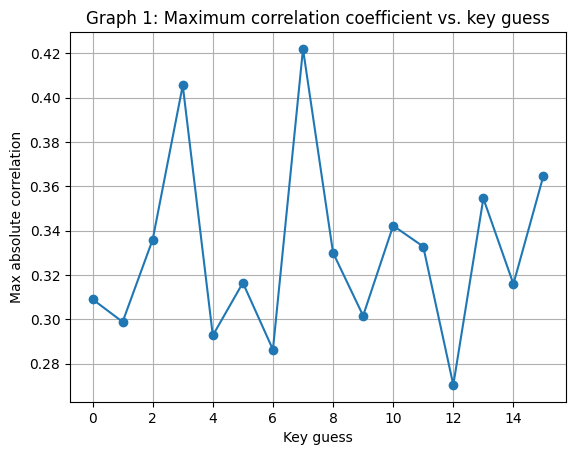

In [79]:
# === Graph 1: Maximum correlation per key guess ===
plt.figure()
plt.plot(np.max(correlation_matrix, axis=1), marker='o')
plt.title("Graph 1: Maximum correlation coefficient vs. key guess")
plt.xlabel("Key guess")
plt.ylabel("Max absolute correlation")
plt.grid()
plt.show()

 • Correlation coefficient vs. sample (time) for all key guesses

In the case of the Value model, the resulting graph shows that key 7 yields the highest correlation, but the value remains relatively low (only 0.42). This suggests that the model is not particularly effective for this dataset and does not provide a clear distinction between the possible key candidates.


Additionally, the other graphs produced by this model are less relevant, as we have already determined that the model does not provide meaningful insights for our analysis.



 • Correlation coefficient vs. sample (time) for all key guesses

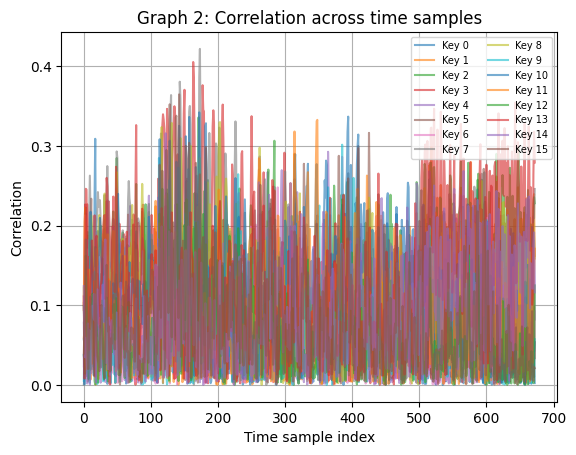

In [83]:
# === Graph 2: Correlation across time for each key guess ===
plt.figure()
for key_guess in range(16):
    plt.plot(correlation_matrix[key_guess], label=f'Key {key_guess}', alpha=0.6)
plt.title("Graph 2: Correlation across time samples")
plt.xlabel("Time sample index")
plt.ylabel("Correlation")
plt.legend(fontsize=7, ncol=2)
plt.grid()
plt.show()

 • Correlation coefficient vs. number of traces for all key guesses

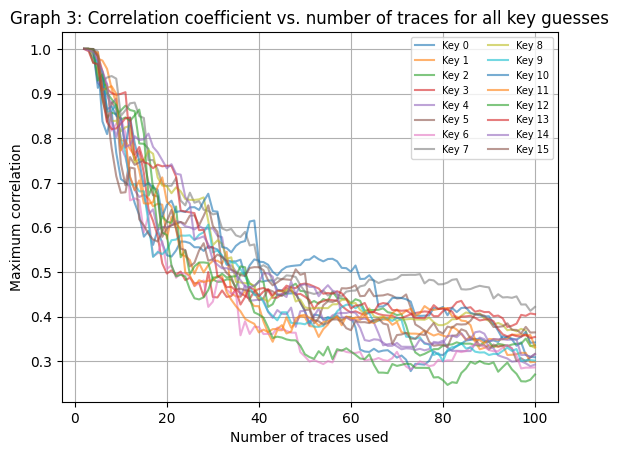

In [ ]:
# === Graph 3: Correlation vs. number of traces ===
trace_counts = []
keywise_correlations = [[] for _ in range(16)]

# Loop over increasing number of traces (starting from 2 up to all available)
for n_traces in range(2, len(plaintexts) + 1):
    trace_counts.append(n_traces)
    # For each possible key guess (total of 16 possibilities for 4-bit key)
    for key_guess in range(16):
        max_corr = 0 
        # Loop over all time samples in the power traces
        for time_idx in range(num_samples):
            x = hypothetical_leakage[:n_traces, key_guess]  # Hypothetical leakage values
            y = traces[:n_traces, time_idx]  # Measured power values at the current time sample
            # Skip cases where all values are constant (correlation is undefined or zero)
            if np.all(x == x[0]) or np.all(y == y[0]):
                continue
            # Compute the Pearson correlation between simulated leakage and real trace
            corr = abs(pearsonr(x, y)[0])
            # Update max_corr if the current correlation is higher
            if not np.isnan(corr) and corr > max_corr:
                max_corr = corr
        # Store the maximum correlation for this key guess at this trace count
        keywise_correlations[key_guess].append(max_corr)

plt.figure()
for key_guess in range(16):
    plt.plot(trace_counts, keywise_correlations[key_guess], label=f'Key {key_guess}', alpha=0.6)
plt.title("Graph 3: Correlation coefficient vs. number of traces for all key guesses")
plt.xlabel("Number of traces used")
plt.ylabel("Maximum correlation")
plt.legend(fontsize=7, ncol=2)
plt.grid()
plt.show()

 • Correlation ratio vs. number of traces

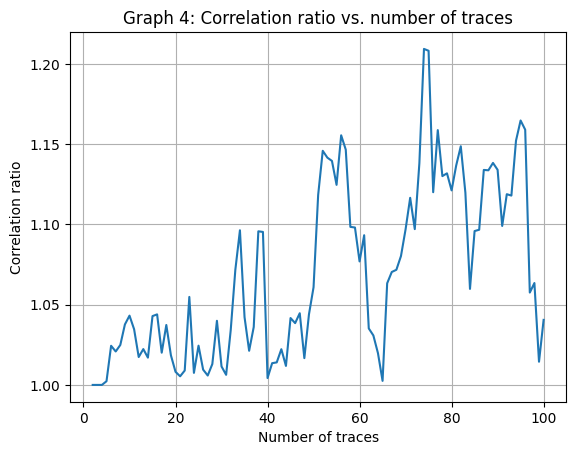

In [ ]:
# === Graph 4: Correlation ratio (best vs second-best) as traces increase ===
correlation_ratios = []
# Loop over each trace count index (i.e., how many traces were used)
for i in range(len(trace_counts)):
    # Get the maximum correlation value for each key guess at the current trace count
    all_corrs = [keywise_correlations[k][i] for k in range(16)]
    sorted_corrs = sorted(all_corrs, reverse=True)
    # Compute the ratio between the highest and second-highest correlations
    # This helps show how clearly the correct key stands out
    ratio = sorted_corrs[0] / sorted_corrs[1] if sorted_corrs[1] != 0 else 0
    # Store the computed ratio
    correlation_ratios.append(ratio)

plt.figure()
plt.plot(trace_counts, correlation_ratios)
plt.title("Graph 4: Correlation ratio vs. number of traces")
plt.xlabel("Number of traces")
plt.ylabel("Correlation ratio")
plt.grid()
plt.show()

  #### iii: Identify the exact clock cycle where the leakage is most significant. Plot the 
   #### corresponding correlation coefficient as a function of the number of traces

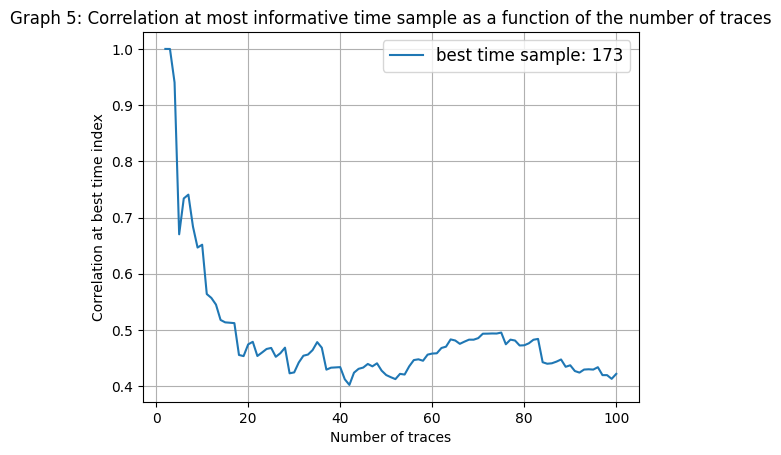

In [ ]:
# === Graph 5: Correlation at best sample over increasing traces ===
fixed_point_corr = []
trace_counts_fixed = []

# Iterate over increasing number of traces, starting from 2 up to the total number of plaintexts
for n_traces in range(2, len(plaintexts) + 1):
    max_corr = 0  
    # Try all possible key guesses (from 0 to 15)
    for key_guess in range(16):
        # Extract the hypothetical leakage and the power trace values at the best time sample
        x = hypothetical_leakage[:n_traces, key_guess]
        y = traces[:n_traces, best_sample]
        # Skip if all values are constant (correlation is undefined or not meaningful)
        if np.all(x == x[0]) or np.all(y == y[0]):
            continue
        # Compute the absolute Pearson correlation
        corr = abs(pearsonr(x, y)[0])
        # Update max correlation if this is the highest seen so far for this number of traces
        if not np.isnan(corr) and corr > max_corr:
            max_corr = corr
    fixed_point_corr.append(max_corr)
    trace_counts_fixed.append(n_traces)

plt.figure()
plt.plot(trace_counts_fixed, fixed_point_corr, label=f'best time sample: {best_sample}')
plt.title("Graph 5: Correlation at most informative time sample as a function of the number of traces")
plt.xlabel("Number of traces")
plt.ylabel("Correlation at best time index")
plt.legend(fontsize=12, ncol=5)
plt.grid()
plt.show()

  #### iv: Determine the best-fitting leakage model for this system’s power consumption.

We can conclude that the Hamming Distance model provides the best fit for the observed leakage, as it yields the highest correlation with the measured samples at the appropriate time point. This result aligns with our expectations: the correct model should closely match the system's actual behavior, with minor deviations due to noise or measurement inaccuracies.

 #### v: Discuss the implications of using incorrect leakage models on large datasets.


The purpose of a leakage model is to approximate how power consumption (or other physical leakage) varies depending on the internal state of the system — typically as a function of inputs and key-dependent operations. When an incorrect leakage model is used, it does not accurately reflect the system’s true behavior. As a result, the correlation between the model and the measured traces may be low even for the correct key, and worse — a wrong key might exhibit the highest correlation simply by chance, especially if its predicted leakages happen to align more closely with the incorrect model.

This issue becomes even more problematic with large datasets. While larger datasets usually reduce noise and improve statistical confidence, they can also introduce a false sense of accuracy when the model is wrong. Specifically:

For small datasets, the effect of noise dominates. If the model is incorrect, the correlations will generally be weak for all keys, and the attack will likely fail — providing a warning sign that the model may be wrong.

For large datasets, the noise averages out, and the correlation becomes more reflective of the underlying model. However, if the model is incorrect, there's a higher risk of false positives: a wrong key might consistently yield high correlation purely due to statistical artifacts, leading the attacker to wrongly conclude it’s the correct key.

This demonstrates the importance of choosing the correct leakage model. A mismatch can not only reduce attack success but also produce misleading results that appear statistically significant but are fundamentally flawed.

## Bonus

If we were to attack a full encryption algorithm (including permutations, additional rounds, and other operations), we might need to modify the attack process because all components of the algorithm need to be taken into account. For example, advanced algorithms include permutations that complicate the physical leakages, and the relationship between the input and output may be more complex.

Possible changes to the attack process:

Reduce the number of measurements at the beginning:
If there are permutations or additional rounds, the influence of the input on the output might become more complex. To avoid confusion or irrelevant noise, it could be beneficial to start with a smaller number of measurements and focus on the most promising ones. After discovering the key, further analysis on the full algorithm can be done.

Improve key identification:
When there is a full encryption algorithm, each round and permutation may alter the correlation in a specific way. Therefore, the attack process may need to be done in stages. In the first stage, it would make sense to focus on removing the effects of permutations, and in the second stage, use this information to break down each round individually.

Decryption after key discovery:
Once the key is found, decrypting the entire process would be much easier. If each stage of the attack is successful, the key can be used to decrypt the remaining parts of the algorithm and ensure the process is being executed correctly.

Adding stages to improve correlation accuracy:
When the algorithm includes multiple stages (like additional encryption rounds), the correlation might not be significant enough in one step. Therefore, we would need to go through each step separately and adjust the correlation to ensure the correct key is identified.